In [1]:
## Import Libraries

import astropy as astro
import astropy.units as u
import astropy.wcs as wcs
import gausspy as gp
import gausspy.gp
import gausspyplus as gpp
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy as sci
import scipy.optimize
import sympy as sp

import csv
import dis
import inspect
import os
import sys

from astropy import units as u
from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
from astropy.io import misc
from astropy.table import QTable, Table, Column
from astropy.visualization import astropy_mpl_style
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch

from datetime import datetime

from gausspyplus.prepare import GaussPyPrepare
from gausspyplus.decompose import GaussPyDecompose

from IPython.display import display_html

from numpy import format_float_scientific as sci

from photutils import detect_sources
from photutils import source_properties
from photutils import EllipticalAperture

from scipy.optimize import *
from scipy import spatial


#plt.style.use(astropy_mpl_style)
%matplotlib inline
#mpl.use("pgf")
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": [
         "\\usepackage{units}",          # load additional packages
         "\\usepackage{metalogo}",
         "\\usepackage{unicode-math}",   # unicode math setup
         r"\setmathfont{xits-math.otf}",
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
         ]
})

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000

In [2]:
def createFolder(directory): ##https://gist.github.com/keithweaver/562d3caa8650eefe7f84fa074e9ca949
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

## Part One

In [3]:

# The columns in this table are: (these aren't the actual column names)

# (1) galaxy name
# (2) ratio of Hbeta flux to Halpha flux
# (3) note on Hbeta flux ratio
# (4) ratio of [OIII] 5007 flux to Halpha flux
# (5) note on [OIII] flux ratio
# (6) ratio of [OI] 6300 flux to Halpha flux
# (7) note on [OI] flux ratio
# (8) ratio of [NII] 6583 flux to Halpha flux
# (9) note on [NII] flux ratio
# (10) log of (the observed Halpha flux in units of erg/cm^2/s)
# (11) note on the log of the observed Halpha flux
# (12) log of (the Halpha luminosity in units of erg/s)
# (13) note on the log of the Halpha luminosity
# (14) equivalent width of the Halpha line (units of Angstroms)
# (15) note on the Halpha equivalent width
# (16) FWHM of the [NII] 6583 line (units of km/s)
# (17) note on the [NII] line width

# The notes mean:

#  L = 3 sigma lower limit
#  u = 3 sigma upper limit
#  s = line strength obtained by scaling the intensity of another line
#  b = value with substantial uncertainty of +/- 30-50%
#  c = value with very substantial uncertainty of +/- 100%

galaxOg = pd.read_csv("./dataTable1.csv",sep=',')
#df['[NII]6583 FWHM note']
#df.where(df.notnull(), None,inplace=True)
#galaxOG['[NII]6583 FWHM note'].fillna('', inplace=True)
galaxOg.replace(r'^\s*$', np.nan, regex=True,inplace=True)
galaxOg.replace(['u ', 'c ', 'b ', 's '], ['u', 'c', 'b', 's'],inplace=True)
galaxOg.shape

(418, 17)

In [4]:
galaxOgFilt = galaxOg.query(" `Hbeta` == `Hbeta` ")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007` == `[OIII]5007` ")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583` == `[NII]6583` ")
c = str('c')
b = str('b')
sb = str('sb')
galaxOgFilt = galaxOgFilt.query(" `Hbeta note` != @c ")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007 note` != @c ")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583 note` != @c ")

galaxOgFilt = galaxOgFilt.query(" `Hbeta note` != @b")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007 note` != @b")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583 note` != @b")

galaxOgFilt = galaxOgFilt.query(" `Hbeta note` != @sb")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007 note` != @sb")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583 note` != @sb")
#galaxOgFilt = galaxOgFilt.reset_index()
galaxOgFilt.shape

(294, 17)

In [5]:
#subtest = test[test['Hbeta note'] == 'u ']
#galaxOgFilt.replace(['u ', 'c ', 'b ', 's '], ['u', 'c', 'b', 's'],inplace=True)
#display(subtest)
#galaxOgFilt['Hbeta note'].unique()

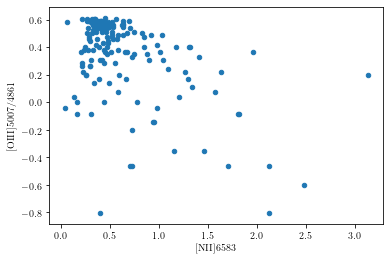

In [6]:
galaxOgFilt['[OIII]5007 ratio'] = galaxOgFilt['[OIII]5007'].astype(np.float) / galaxOgFilt['Hbeta'].astype(np.float)

galaxOgFilt['[NII]6583 ratio'] = galaxOgFilt['[NII]6583'].astype(np.float) / galaxOgFilt['Hbeta'].astype(np.float)
galaxOgFilt['[OIII]5007/4861'] = np.log10(4.2 - 9.4*galaxOgFilt['[OIII]5007'].astype(np.float))
galaxOgFilt.plot(kind='scatter', x = '[NII]6583', y = '[OIII]5007/4861')

#plt.show()

## Part Two

In [7]:
fileIndex = [1,2,3,4,5,6,7,8,9,10]
emGal = [pd.read_csv('./spectrum'+str(i)+'.txt', sep = '    ',
                     header=None, names=["Rest Wavelength","Flux Density"],
                     engine = "python") for i in fileIndex]
absGal = [pd.read_csv('./partner'+str(i)+'.txt', sep = '    ',
                     header=None, names=["Rest Wavelength","Flux Density"],
                     engine = "python") for i in fileIndex]

In [8]:
# ax1 = emGal[9].plot(kind='scatter', x = 'Rest Wavelength',y='Flux Density')
# absGal[9].plot(kind='scatter', x = 'Rest Wavelength',y='Flux Density', ax =ax1)
# plt.show()

In [9]:
def galPair(pairNum=0): ## Just takes an int from 1-10 and returns emmission and absorption DataFrames
    ind = pairNum - 1
    if ind < 0:
        print('add an argument between 1 and 10 for the spectrum pair, ya dingus')
        print('defaulting to pair 01')
        ind = 0
    gal, part = emGal[ind], absGal[ind]
    return gal, part

In [10]:
def trim(pairNum=0, verbose=False, plot=False, savePlot='none'): ## Trims DataFrames so galaxy pairs have matching range
    
    if pairNum <= 0 or pairNum > 10:
        print('add an argument between 1 and 10 for the spectrum pair, ya dingus')
        print('defaulting to pair 01')
        pair = 1
        pairStr = str(0)+str(pair)
    elif pairNum != 10:
        pair = pairNum
        pairStr = str(0)+str(pair)
    elif pairNum == 10:
        pair = pairNum
        pairStr = str(pair)
    gal, part = galPair(pair)
    #galMax = gal['Rest Wavelength'].max()
    #partMax = part['Rest Wavelength'].max()
    if gal['Rest Wavelength'].max() <= part['Rest Wavelength'].max():
        plusle = gal['Rest Wavelength'].max() ## Max value of spectra emmission lines
        partFilt = part.query('`Rest Wavelength` <= @plusle')
        galFilt = gal.query('`Rest Wavelength` <= @plusle')
        #print('gal.max<part.max')
    elif gal['Rest Wavelength'].max() >= part['Rest Wavelength'].max(): 
        plusle = part['Rest Wavelength'].max() ## Max value of absorption lines
        galFilt = gal.query('`Rest Wavelength` <= @plusle')
        partFilt = part.query('`Rest Wavelength` <= @plusle')
        #print('gal.max>part.max')
    
    #galMin = gal['Rest Wavelength'].min()
    #partMin = part['Rest Wavelength'].min()   
    if gal['Rest Wavelength'].min() >= part['Rest Wavelength'].min():
        minun = gal['Rest Wavelength'].min() ## Min Value of emmission lines
        partFilt = partFilt.query('`Rest Wavelength` >= @minun')
        galFilt = galFilt.query('`Rest Wavelength` >= @minun')
        #print('gal.min>part.min')
    elif gal['Rest Wavelength'].min() <= part['Rest Wavelength'].min():
        minun = part['Rest Wavelength'].min() ## Min Value of partner absorption lines
        galFilt = galFilt.query('`Rest Wavelength` >= @minun')
        partFilt = partFilt.query('`Rest Wavelength` >= @minun')
        #print('gal.min<part.min')
    
    if verbose:
        galCut = np.abs(gal.shape[0] - galFilt.shape[0])
        partCut = np.abs(part.shape[0] - partFilt.shape[0])
        galCent = 100*( galCut / gal.shape[0] )
        galCent = np.around(galCent,2)
        partCent = 100*(partCut /part.shape[0])
        partCent = np.around(partCent,2)
        
        print("galaxy pair "+pairStr)
        print("minimum wavelength: ",minun," Angstroms")
        print("maximum wavelength",plusle," Angstroms")
        #print("number of points removed from emission line: ",galCut)
        #print("number of points removed from absorption line: ",partCut)
        print("percent of emission line data points removed: ", galCent,"%")
        print("percent of absorption line data points removed: ", partCent,"%")
        print("number of emission line data points after cut: ",galFilt.shape[0])
        print("number of absorption line data points after cut:",partFilt.shape[0])
        print()
        
    if plot:
        tit = str("Flux Density vs. Rest Wavelength \n for Galaxy Pair "+pairStr)
        axTrim = galFilt.plot(
            x ='Rest Wavelength',y='Flux Density', 
            color='orange', label='Emission Line\n Galaxies')
        partFilt.plot(
            x ='Rest Wavelength',y='Flux Density',
            color='blue', label='Absorption Line\n Galaxies',
            title=tit, ax =axTrim)
        if savePlot != 'none':
            createFolder('./galaxyPairPlots/')
            directory = './galaxyPairPlots/'
            
            if savePlot == 'trim':
                #print('saving trimmed wavelength plot...')
                mpl.pyplot.savefig(directory+'trimWavelength'+pairStr+'.png',bbox_inches='tight')
                #print('trimmed plot saved')
                plt.show()
            elif savePlot == 'both':
                #print('saving trimmed wavelength plot...')
                mpl.pyplot.savefig(directory+'trimWavelength'+pairStr+'.png',bbox_inches='tight')
                #print('trimmed plot saved')
                plt.show()
                plt.clf()
                #print('saving full wavelength plot...')
                axUntrim = gal.plot(
                    x ='Rest Wavelength',y='Flux Density', 
                    color='purple', label='Emission Line\n Galaxies')
                part.plot(
                    x ='Rest Wavelength',y='Flux Density',
                    color='pink', label='Absorption Line\n Galaxies',
                    title=tit+' (Untrimmed)', ax =axUntrim)
                plt.axvline(x=plusle,color='black',linestyle='dashed')
                plt.axvline(x=minun,color='black',linestyle='dashed')
                mpl.pyplot.savefig(directory+'fullWavelength'+pairStr+'.png',bbox_inches='tight')
                #print('full wavelength plot saved')
                plt.show()
            else:
                print(str(savePlot)+' is not a valid argument!')
                print('arguments for savePlot (strings): none, trim, both')
        elif savePlot == 'none':
            plt.show()
    if plot is False and savePlot != 'none':
        print('WARNING: Plot will not be saved without adding the argument `plot=True`')
    return galFilt, partFilt


In [11]:
# for i in range(1,11):
#     trim(pairNum= i ,verbose=True,plot=True,savePlot='both')

In [12]:
# s1t, p1t = trim(pairNum=1)
# #display(s1t)
# s1t['Rest Wavelength'] = s1t['Rest Wavelength']
# p1t['Rest Wavelength'] = p1t['Rest Wavelength']
# s1tr = s1t.set_index('Rest Wavelength')
# p1tr = p1t.set_index('Rest Wavelength')
# #display(s1tr)

In [13]:
# min1 = round(s1tr.index.min())
# #print(min1)
# max1 = round(s1tr.index.max())
# #print(max1)
# len1 = round(max1-min1)
# #print(len(s1tr.index))
# #print(len1)
# newIndex1 = np.linspace(min1,max1-1,len1)
# #print(newIndex1)

# interp1s = pd.DataFrame(index=newIndex1)
# interp1s.index.name = s1tr.index.name

# interp1p = pd.DataFrame(index=newIndex1)
# interp1p.index.name = p1tr.index.name
# #display(interp1s)

# for colname, col in s1tr.iteritems():
#     interp1s[colname] = np.interp(newIndex1,s1tr.index,col)
# for colname, col in p1tr.iteritems():
#     interp1p[colname] = np.interp(newIndex1,p1tr.index,col)
# display_side_by_side(p1tr,interp1p)

In [14]:
def interpolate(pairNum=0, verbose=False, plot=False, savePlot=False): ## Interpolates pair to 
    ## matching index
    if pairNum <= 0 or pairNum > 10:
        print('add an argument between 1 and 10 for the spectrum pair, ya dingus')
        print('defaulting to pair 01')
        pair = 1
        pairStr = str(0)+str(pair)
    elif pairNum != 10:
        pair = pairNum
        pairStr = str(0)+str(pair)
    elif pairNum == 10:
        pair = pairNum
        pairStr = str(pair)
    
    gal, part = trim(pairNum=pair)
    galRe = gal.set_index('Rest Wavelength')
    partRe = part.set_index('Rest Wavelength')
    galLength = round(len(galRe.index))
    partLength = round(len(partRe.index))
    if galLength >= partLength:
        minun = round(partRe.index.min())
        plusle = round(partRe.index.max())
    elif galLength <= partLength:
        minun = round(galRe.index.min())
        plusle = round(galRe.index.max())
    
    numPoints = round(abs(plusle-minun))
    newIndex = np.linspace(minun,plusle-1,numPoints) ## need to subtract one from max to keep range correct
    
    galInt = pd.DataFrame(index=newIndex)
    galInt.index.name = galRe.index.name
    
    partInt = pd.DataFrame(index=newIndex)
    partInt.index.name = partRe.index.name
    
    for colname, col in galRe.iteritems():
        galInt[colname] = np.interp(newIndex,galRe.index,col)
    for colname, col in partRe.iteritems():
        partInt[colname] = np.interp(newIndex,partRe.index,col)
    galInt.reset_index(inplace=True)
    partInt.reset_index(inplace=True)
    
    if verbose:
        numPointsDiff = abs(galLength - partLength)
        print("galaxy pair "+pairStr)
        print("minimum wavelength: ",minun," Angstroms")
        print("maximum wavelength",plusle," Angstroms")
        if galLength >= partLength:
            print('emission line galaxy has ',numPointsDiff,' more data points than the partner absorption line galaxy')
        elif galLength <= partLength:
            print('emission line galaxy has ',numPointsDiff,' fewer data points than the partner absorption line galaxy')
    if plot:
        tit = str('Effects of interpolation for Galaxy Pair '+str(pairStr))
        axGal = gal.plot(
            x ='Rest Wavelength',y='Flux Density', 
            color='purple', label='Original Emission Lines', 
            title=tit, lw=4)
        galInt.plot(
            x ='Rest Wavelength',y='Flux Density',
            color='orange', label='Interpolated Emission Lines',
            ax =axGal)
        part.plot(
            x ='Rest Wavelength',y='Flux Density',
            color='pink', label='Original Absorption Lines', 
            lw=4, ax =axGal)
        partInt.plot(
            x ='Rest Wavelength',y='Flux Density',
            color='blue', label='Interpolated Absorption Lines', 
            ax =axGal)
        if savePlot:
            createFolder('./galaxyPairPlots/')
            directory = './galaxyPairPlots/'
            mpl.pyplot.savefig(directory+'interpWavelengths'+pairStr+'.png',bbox_inches='tight')
        plt.show()
    if plot is False and savePlot:
        print('WARNING: Plot will not be saved without the argument `plot=True`')
    
    return galInt, partInt

In [15]:
# galInt, partInt = interpolate(10)
# frac = (galInt/partInt)
# def testFunc(x):
#     func = galInt['Flux Density'] - x*partInt['Flux Density']
#     return func

# test = least_squares(testFunc, frac['Flux Density'].mean())#,loss='soft_l1')
# testS = least_squares(testFunc, frac['Flux Density'].mean(),loss='soft_l1',f_scale=0.1)
# print(test.x)
# const = np.float(test.x)
# const = np.float(testS.x)
# #frac['Flux Density'].mean()
# new = pd.DataFrame(index=galInt.index)
# new.index.name = galInt.index.name
# # display(new)
# new['Rest Wavelength'] = galInt['Rest Wavelength']
# new['Flux Density'] = galInt['Flux Density'] - const*partInt['Flux Density']
# display(new['Flux Density'].median())
# ax = new.plot(x='Rest Wavelength',y='Flux Density',color='orange',label='ls diff')
# galInt.plot(x='Rest Wavelength',y='Flux Density',color='green',ax=ax,label='emm')
# partInt.plot(x='Rest Wavelength',y='Flux Density',color='blue',ax=ax,label='abs')
# plt.show()

In [16]:
def scaleSub(pairNum=0, verbose=False,plot=False,savePlot=False,table=False,method='rls'):
    if pairNum <= 0 or pairNum > 10:
        print('add an argument between 1 and 10 for the spectrum pair, ya dingus')
        print('defaulting to pair 01')
        pair = 1
        pairStr = str(0)+str(pair)
    elif pairNum != 10:
        pair = pairNum
        pairStr = str(0)+str(pair)
    elif pairNum == 10:
        pair = pairNum
        pairStr = str(pair)
    gal, part = interpolate(pair)
    rat = abs(gal/part)
    optFunc = lambda x: gal['Flux Density'] - x*part['Flux Density']
    
    ls = least_squares(optFunc, rat['Flux Density'].median())
    ls_scale = float(ls.x)
    ls_soft = least_squares(optFunc, rat['Flux Density'].median(),loss='soft_l1',f_scale=0.1)
    ls_soft_scale =  float(ls_soft.x)
    
    ls_part_scale = pd.DataFrame(index=part.index)
    ls_part_scale['Rest Wavelength'] = part['Rest Wavelength']
    ls_part_scale['Flux Density'] = ls_scale*part['Flux Density']
    ls_spec = pd.DataFrame(index=gal.index)
    ls_spec['Rest Wavelength'] = gal['Rest Wavelength']
    ls_spec['Flux Density'] = gal['Flux Density'] - ls_part_scale['Flux Density']
    
    ls_soft_part_scale = pd.DataFrame(index=part.index)
    ls_soft_part_scale['Rest Wavelength'] = part['Rest Wavelength']
    ls_soft_part_scale['Flux Density'] = ls_soft_scale*part['Flux Density']
    ls_soft_spec = pd.DataFrame(index=gal.index)
    ls_soft_spec['Rest Wavelength'] = gal['Rest Wavelength']
    ls_soft_spec['Flux Density'] = gal['Flux Density'] - ls_soft_part_scale['Flux Density']
    
    scaleDiff  = abs(ls_scale-ls_soft_scale)
    ls_avg = round(ls_spec['Flux Density'].mean(),5)
    ls_std = round(ls_spec['Flux Density'].std(),5)
    ls_med = round(ls_spec['Flux Density'].median(),5)
    ls_soft_avg = round(ls_soft_spec['Flux Density'].mean(),5)
    ls_soft_std = round(ls_soft_spec['Flux Density'].std(),5)
    ls_soft_med = round(ls_soft_spec['Flux Density'].median(),5)
    avgDiff = round(abs(ls_avg-ls_soft_avg),5)
    stdDiff = round(abs(ls_std-ls_soft_std),5)
    #avgDiffPower = math.floor(math.log10(avgDiff))
    medDiff = round(abs(ls_med-ls_soft_med),5)
    #medDiffPower = math.floor(math.log10(medDiff))
    
    if table:
        tabDat = {'Galaxy Pair': [pair],
                  'Wavelength Min': [gal['Rest Wavelength'].min()],
                  'Wavelength Max': [gal['Rest Wavelength'].max()],
                  'Mean Emission Flux': [gal['Flux Density'].mean()],
                  'Mean Absorption Flux': [part['Flux Density'].mean()],
                  'Least Square Scale Factor': [round(ls_scale,5)],
                  'Robust Least Square Scale Factor': [round(ls_soft_scale,5)],
                  'Least Square Mean Star-Free Emission Line Flux': [ls_avg],
                  'Least Square Star-Free Emission Line Flux STD': [ls_avg],
                  'Robust Least Square Mean Star-Free Emission Line Flux': [ls_soft_avg],
                  'Robust Least Square Star-Free Emission Line Flux STD': [ls_soft_avg],
                  'Least Square Median Star-Free Emission Line Flux': [ls_med],
                  'Robust Least Square Median Star-Free Emission Line Flux': [ls_soft_med],
                  'Method Mean Difference': [avgDiff],
                  'Method STD Difference': [stdDiff],
                  'Method Median Difference': [medDiff]
                 }
        cols = ['Galaxy Pair','Wavelength Min','Wavelength Max',
                'Mean Emission Flux','Mean Absorption Flux',
                'Least Square Scale Factor','Robust Least Square Scale Factor',
                'Least Square Mean Subtracted Emission Flux', 
                'Least Square Star-Free Emission Line Flux STD',
                'Robust Least Square Mean Star-Free Emission Line Flux',
                'Robust Least Square Star-Free Emission Line Flux STD',
                'Least Square Median Star-Free Emission Line Flux',
                'Robust Least Square Median Star-Free Emission Line Flux',
                'Method Mean Difference','Method STD Difference',
                'Method Median Difference'
               ]
        df = pd.DataFrame(tabDat,columns=cols)
    
    if verbose:
        print("galaxy pair "+pairStr)
        print('least square method:')
        print('scale factor: ',round(ls_scale,5),'x')
        print('star-free emission line average: ',ls_avg,
              ' angstroms (std: ',ls_std,')')
        print('star-free emission line median: ',ls_med,
              ' angstroms')
        print()
        print('robust least square method:')
        print('scale factor: ',round(ls_soft_scale,5),'x')
        print('star-free emission line average: ',ls_soft_avg,
              ' angstroms (std: ',ls_soft_std,')')
        print('star-free emission line median: ',ls_soft_med,
              ' angstroms')
        print()
        print('average flux between methods differ by ',avgDiff)
        print('standard deviation of flux bettween methods differ by ',stdDiff)
        print('median flux between methods differ by ',medDiff)
    
    if plot:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7.5))
        fig.tight_layout(h_pad=-1.0)
        fig.suptitle('Calculation Methods of Flux Density Scaling\n and Star-Free Emission Line\n for Galaxy Pair '+pairStr,
                     y=1.12,fontsize=16)
        x1 = ls_spec['Rest Wavelength']
        y1 = ls_spec['Flux Density']
        ax1.plot(x1, y1,
                 color='orange', label='star-free emission line')
        ax1.plot(gal['Rest Wavelength'],gal['Flux Density'],
                 color='green', label='emission line')
        ax1.plot(part['Rest Wavelength'], part['Flux Density'],
                 color='blue',label='absorption line')
        ax1.plot(ls_part_scale['Rest Wavelength'],ls_part_scale['Flux Density'],
                 color='darkblue',label='scaled absorption line',alpha=0.6)
        ax1.set_xlabel('Rest Wavelength')
        ax1.set_ylabel('Flux Density')
        ax1.set_title('Least Square Method')
        ax1.set_ylim(bottom=-6)
        if pair == 1 or pair == 8 or pair == 10:
            ax1.legend(bbox_to_anchor=(0.3,0.6),loc=1)
        else:
            ax1.legend(bbox_to_anchor=(0.3,0.8),loc=1)
        
        x2 = ls_soft_spec['Rest Wavelength']
        y2 = ls_soft_spec['Flux Density']
        ax2.plot(x2, y2,
                 color='orange', label='star-free emission line')
        ax2.plot(gal['Rest Wavelength'],gal['Flux Density'],
                 color='green', label='emission line')
        ax2.plot(part['Rest Wavelength'], part['Flux Density'],
                 color='blue',label='absorption line')
        ax2.plot(ls_soft_part_scale['Rest Wavelength'],ls_soft_part_scale['Flux Density'],
                 color='darkblue',label='scaled absorption line',alpha=0.6)
        ax2.set_xlabel('Rest Wavelength')
        ax2.set_title('Robust Least Square Method')
        ax2.set_ylim(bottom=-6)
        if pair == 1 or pair == 8 or pair == 10:
            ax2.legend(bbox_to_anchor=(0.3,0.6),loc=1)
        else:
            ax2.legend(bbox_to_anchor=(0.3,0.8),loc=1)
        
        if savePlot:
            createFolder('./galaxyPairPlots/')
            directory = './galaxyPairPlots/'
            fig.savefig(directory+'scaleMethods'+pairStr+'.png',bbox_inches='tight')
            
        plt.show()
    if plot is False and savePlot:
        print('WARNING: Plot will not be saved without the argument `plot=True`')
    if method == 'ls':
        if table:
            return ls_spec, df
        elif table is False:
            return ls_spec
    elif method == 'rls' or method == 'ls_soft':
        if table:
            return ls_soft_spec, df
        elif table is False:
            return ls_soft_spec
    elif method == 'both':
        if table:
            return ls_spec, ls_soft_spec, table
        elif table is False:
            return ls_spec, ls_soft_spec

In [17]:
# for i in fileIndex:
#     scaleSub(pairNum=i,verbose=True,plot=True,savePlot=True)

In [18]:
def tabler(save=False,colList=[]):
    tabDic = [scaleSub(ind,method='rls',table=True)[1] for ind in fileIndex]
    tab = pd.concat(tabDic)
    tab.reset_index(inplace=True)
    tab.drop(columns='index',inplace=True)
    cols = tab.columns.values.tolist()
    if colList:
        cols = [name for name in cols if name in colList]
        if save:
            directory = './galaxyPairTables/'
            fileName = str('galaxyPairTable('+str(len(cols))+'col)')
            createFolder(directory)
            tab.to_latex(directory+fileName+'.tex', columns = cols, longtable=True,
                         index = False,
                         caption = 'Flux Scaling')
            tab.to_html(directory+fileName+'.html', index = False)
            
    else:
        if save:
            directory = './galaxyPairTables/'
            fileName = 'galaxyPairTableFull'
            createFolder(directory)
            tab.to_latex(directory+fileName+'.tex', columns = cols, longtable=True,
                         index = False,
                         caption = 'Flux Scaling')
            tab.to_html(directory+fileName+'.html', index = False)
    return tab
    

In [19]:
#tabler(save=True)

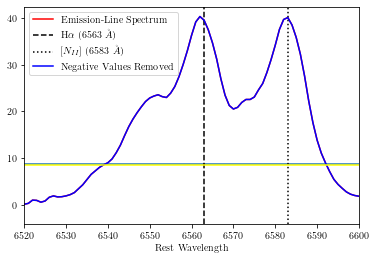

In [20]:
gal= scaleSub(3)
#gal[gal < 0] = 0
ax = gal.plot(x='Rest Wavelength',y='Flux Density',color='red',
              xlim=(6520,6600), label='Emission-Line Spectrum')
plt.axhline(y=gal['Flux Density'].std())
plt.axvline(x=6563,label=r'H$\alpha$ (6563 $\AA$)',
           linestyle='dashed',color='black')
plt.axvline(x=6583,label=r'[$N_{II}$] (6583 $\AA$)',
           linestyle='dotted',color='black')
gal[gal < 0] = 0
gal.plot(x='Rest Wavelength',y='Flux Density',
         color='blue',label='Negative Values Removed',ax=ax)
plt.axhline(y=gal['Flux Density'].std(),color='yellow')
plt.legend()
plt.show()
#display(gal)

In [21]:
# te = gal.query(' `Rest Wavelength` < 6600')
# te.query('`Rest Wavelength` > 6500',inplace=True)
# te['Flux Density'].plot(kind='bar')


In [22]:
def iso(pairNum=0, wl=(6400,6700), lowFilt=False, verbose=False, plot=False, savePlot=False):
    minun = wl[0]
    plusle = wl[1]
    if pairNum <= 0 or pairNum > 10:
        print('add an argument between 1 and 10 for the spectrum pair, ya dingus')
        print('defaulting to pair 01')
        pair = 1
        pairStr = str(0)+str(pair)
    elif pairNum != 10:
        pair = pairNum
        pairStr = str(0)+str(pair)
    elif pairNum == 10:
        pair = pairNum
        pairStr = str(pair)
    gal = scaleSub(pairNum=pair)
    if lowFilt:
        gal[gal < 0] = 0
    portSpec = gal.query(' `Rest Wavelength` >= @minun ')
    portSpec = portSpec.query(' `Rest Wavelength` <= @plusle ')
    if plot:
        portSpec.plot(x='Rest Wavelength',y='Flux Density',color='orange',
                      label='Star-Free Emission-Line Spectrum',figsize=(10,10))
        plt.axvline(x=6548,label=r'[$N_{II}$] (6583 $\AA$)',
                    linestyle='dotted',color='black')
        plt.axvline(x=6563,label=r'H$\alpha$ (6563 $\AA$)',
                    linestyle='dashed',color='black')
        plt.axvline(x=6583,label=r'[$N_{II}$] (6583 $\AA$)',
                    linestyle='dotted',color='black')
        plt.ylabel('Flux Density')
        plt.legend()
        plt.title('Isolated Star-Free Emission-Line\n Spectrum of Galaxy Pair '+pairStr)
        if savePlot:
            directory = './galaxyPairPlots/'
            createFolder(directory)
            mpl.pyplot.savefig(directory+'isolatedSpectrum'+pairStr+'.png',bbox_inches='tight')
        plt.show()
    return portSpec
            

using 6 out of 8 cpus
   ---->   0


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]

SUCCESS
100 finished.%


[[183.3611875377795, 162.5708733952165, 157.6807968126915]]

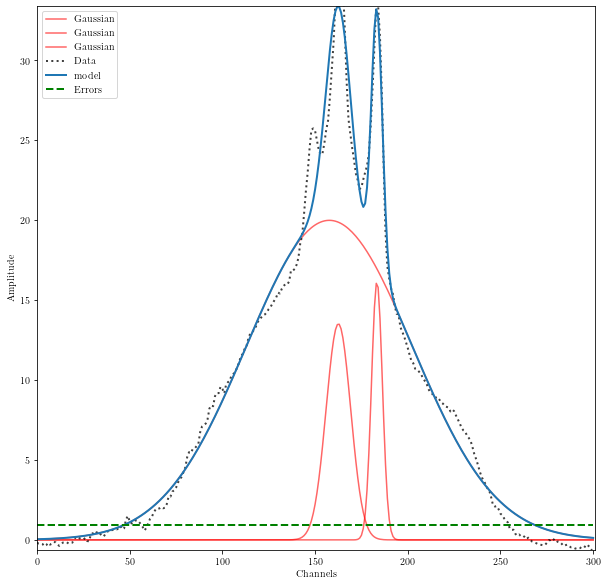

In [24]:
specP = 5
FILENAME = str("test1.pickle".encode('utf-8'))
FILENAME_DATA_DECOMP = 'test1_decomposed.pickle'
NCOMPS = 4
RMS = float(iso(specP)['Flux Density'].std())/10
NCHANNELS = int(iso(specP).shape[0])
data = {}
chan = np.arange(NCHANNELS)
errors = np.ones(NCHANNELS) * RMS
spectrum = iso(specP)['Flux Density'].to_numpy()

data['data_list'] = data.get('data_list', []) + [spectrum]
data['x_values'] = data.get('x_values', []) + [chan]
data['errors'] = data.get('errors', []) + [errors]
op = open(FILENAME, "wb")
pickle.dump(data, op)

alpha1 = 1e-20
snr_thresh = 5.


# Load GaussPy
g = gp.gp.GaussianDecomposer()

# Setting AGD parameters
g.set('phase', 'one')
g.set('SNR_thresh', [snr_thresh, snr_thresh])
g.set('alpha1', alpha1)
#g.set('alpha2', alpha2)

# Run GaussPy
data_decomp = g.batch_decomposition(FILENAME)
#display(data_decomp)
# Save decomposition information
pickle.dump(data_decomp, open(FILENAME_DATA_DECOMP, 'wb'))
unpick = pd.read_pickle(FILENAME_DATA_DECOMP)
#display(unpick)
unpick.keys()



def gaussian(amp, fwhm, mean):
    return lambda x: amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)

def unravel(list):
    return np.array([i for array in list for i in array])

data = pickle.load(open(FILENAME,'rb'), encoding="utf-8")
spectrum = unravel(data['data_list'])
chan = unravel(data['x_values'])
errors = unravel(data['errors'])

data_decomp = pickle.load(open(FILENAME_DATA_DECOMP,'rb'), encoding="utf8")
means_fit = unravel(data_decomp['means_fit'])
amps_fit = unravel(data_decomp['amplitudes_fit'])
fwhms_fit = unravel(data_decomp['fwhms_fit'])

fig = plt.figure(figsize=(10,10))
fig.tight_layout()
ax = fig.add_subplot(111)

model = np.zeros(len(chan))

for j in range(len(means_fit)):
    component = gaussian(amps_fit[j], fwhms_fit[j], means_fit[j])(chan)
    model += component
    ax.plot(chan, component, color='red', lw=1.5,alpha=0.6,label='Gaussian')
lab = str('alpha1='+str(alpha1)+', snr_thresh='+str(snr_thresh))
ax.plot(chan, spectrum, label='Data', color='black', linewidth=2,alpha=0.75,linestyle='dotted')
ax.plot(chan,1.0* model, label = 'model', linewidth=2)
ax.plot(chan, errors, label = 'Errors', color='green', linestyle='dashed', linewidth=2.)

ax.set_xlabel('Channels')
ax.set_ylabel('Amplitude')

ax.set_xlim(0,len(chan))
ax.set_ylim(np.min(spectrum),np.max(model))
ax.legend(loc=2)

#plt.show()
display(data_decomp['means_fit'])

In [ ]:
gp.gp.GaussianDecomposer??

In [27]:
# Specify the number of spectral channels (NCHANNELS)
NCHANNELS = 300

# Specify the number of spectra (NSPECTRA)
NSPECTRA = 200

# Estimate of the root-mean-square uncertainty per channel (RMS)
RMS = iso(1)['Flux Density'].std()

# Estimate the number of components
NCOMPS = 4

# Specify the min-max range of possible properties of the Gaussian function paramters:
AMP_lims = [0.1, 10]
FWHM_lims = [100, 200] # channels
MEAN_lims = [0.25*NCHANNELS, 0.75*NCHANNELS] # channels

# Indicate whether the data created here will be used as a training set
# (a.k.a. decide to store the "true" answers or not at the end)
TRAINING_SET = True

# Specify the pickle file to store the results in
FILENAME = 'training_data.pickle'


# Initialize
data = {}
chan = np.arange(NCHANNELS)
errors = np.ones(NCHANNELS) * RMS

# Begin populating data
for i in range(NSPECTRA):
    spectrum_i = np.random.randn(NCHANNELS) * RMS

    amps = []
    fwhms = []
    means = []

    for comp in range(NCOMPS):
        # Select random values for components within specified ranges
        a = np.random.uniform(AMP_lims[0], AMP_lims[1])
        w = np.random.uniform(FWHM_lims[0], FWHM_lims[1])
        m = np.random.uniform(MEAN_lims[0], MEAN_lims[1])

        # Add Gaussian profile with the above random parameters to the spectrum
        spectrum_i += gaussian(a, w, m)(chan)

        # Append the parameters to initialized lists for storing
        amps.append(a)
        fwhms.append(w)
        means.append(m)

    # Enter results into AGD dataset
    data['data_list'] = data.get('data_list', []) + [spectrum_i]
    data['x_values'] = data.get('x_values', []) + [chan]
    data['errors'] = data.get('errors', []) + [errors]

    # If training data, keep answers
    if TRAINING_SET:
        data['amplitudes'] = data.get('amplitudes', []) + [amps]
        data['fwhms'] = data.get('fwhms', []) + [fwhms]
        data['means'] = data.get('means', []) + [means]

# Dump synthetic data into specified filename
pickle.dump(data, open(FILENAME, 'wb'))



# Set necessary parameters
FILENAME_TRAIN = 'training_data.pickle'
snr_thresh = 5.
alpha1_initial = 0.005
alpha2_initial = 0.5

g = gp.gp.GaussianDecomposer()

# Next, load the training dataset for analysis:
g.load_training_data(FILENAME_TRAIN)

# Set GaussPy parameters
g.set('phase', 'two')
g.set('SNR_thresh', [snr_thresh, snr_thresh])

# Train AGD starting with initial guess for alpha
g.train(alpha1_initial = alpha1_initial, alpha2_initial = alpha2_initial)

Training...

0.005 0.9 nan 0.0
iter 0: F1= 0.0%, alpha=[0.0, 0.5], p=[0.00, 0.00]  (Convergence testing begins in 20 iterations)


LinAlgError: SVD did not converge in Linear Least Squares